<a href="https://colab.research.google.com/github/nalinzip/java_programming/blob/main/ML_week8_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings. filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
house_df_org = pd.read_csv('/content/sample_data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n 전체 피처의 type \n', house_df.dtypes. value_counts())
isnull_series = house_df.isnull().sum()
print('\n Null 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

 Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


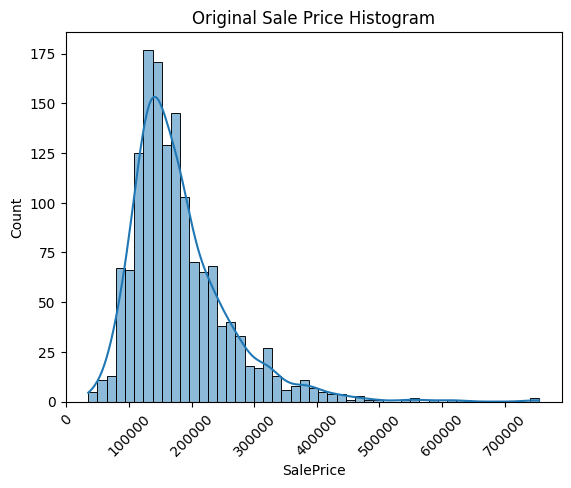

In [3]:
plt.title( 'Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

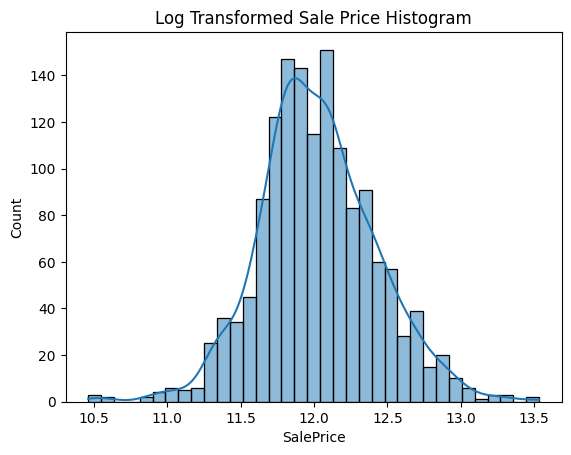

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df ['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True, errors='ignore')

numeric_cols = house_df.select_dtypes(include=np.number).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type : \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [6]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0] # Changed { to (
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index]) # Changed ( to [

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


In [7]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses


In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                   random_state=156)
# LinearRegression, Ridge, Lasso 학습 , 예측 , 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688250857),
 np.float64(0.1274058283626616),
 np.float64(0.17628250556471403)]

In [48]:
def get_top_bottom_coef(model, n=10):
    #coef_ 속성을 기반으로 Series 객체를 생성. index 는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    #+ 상위 10 개 , - 하위 10 개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

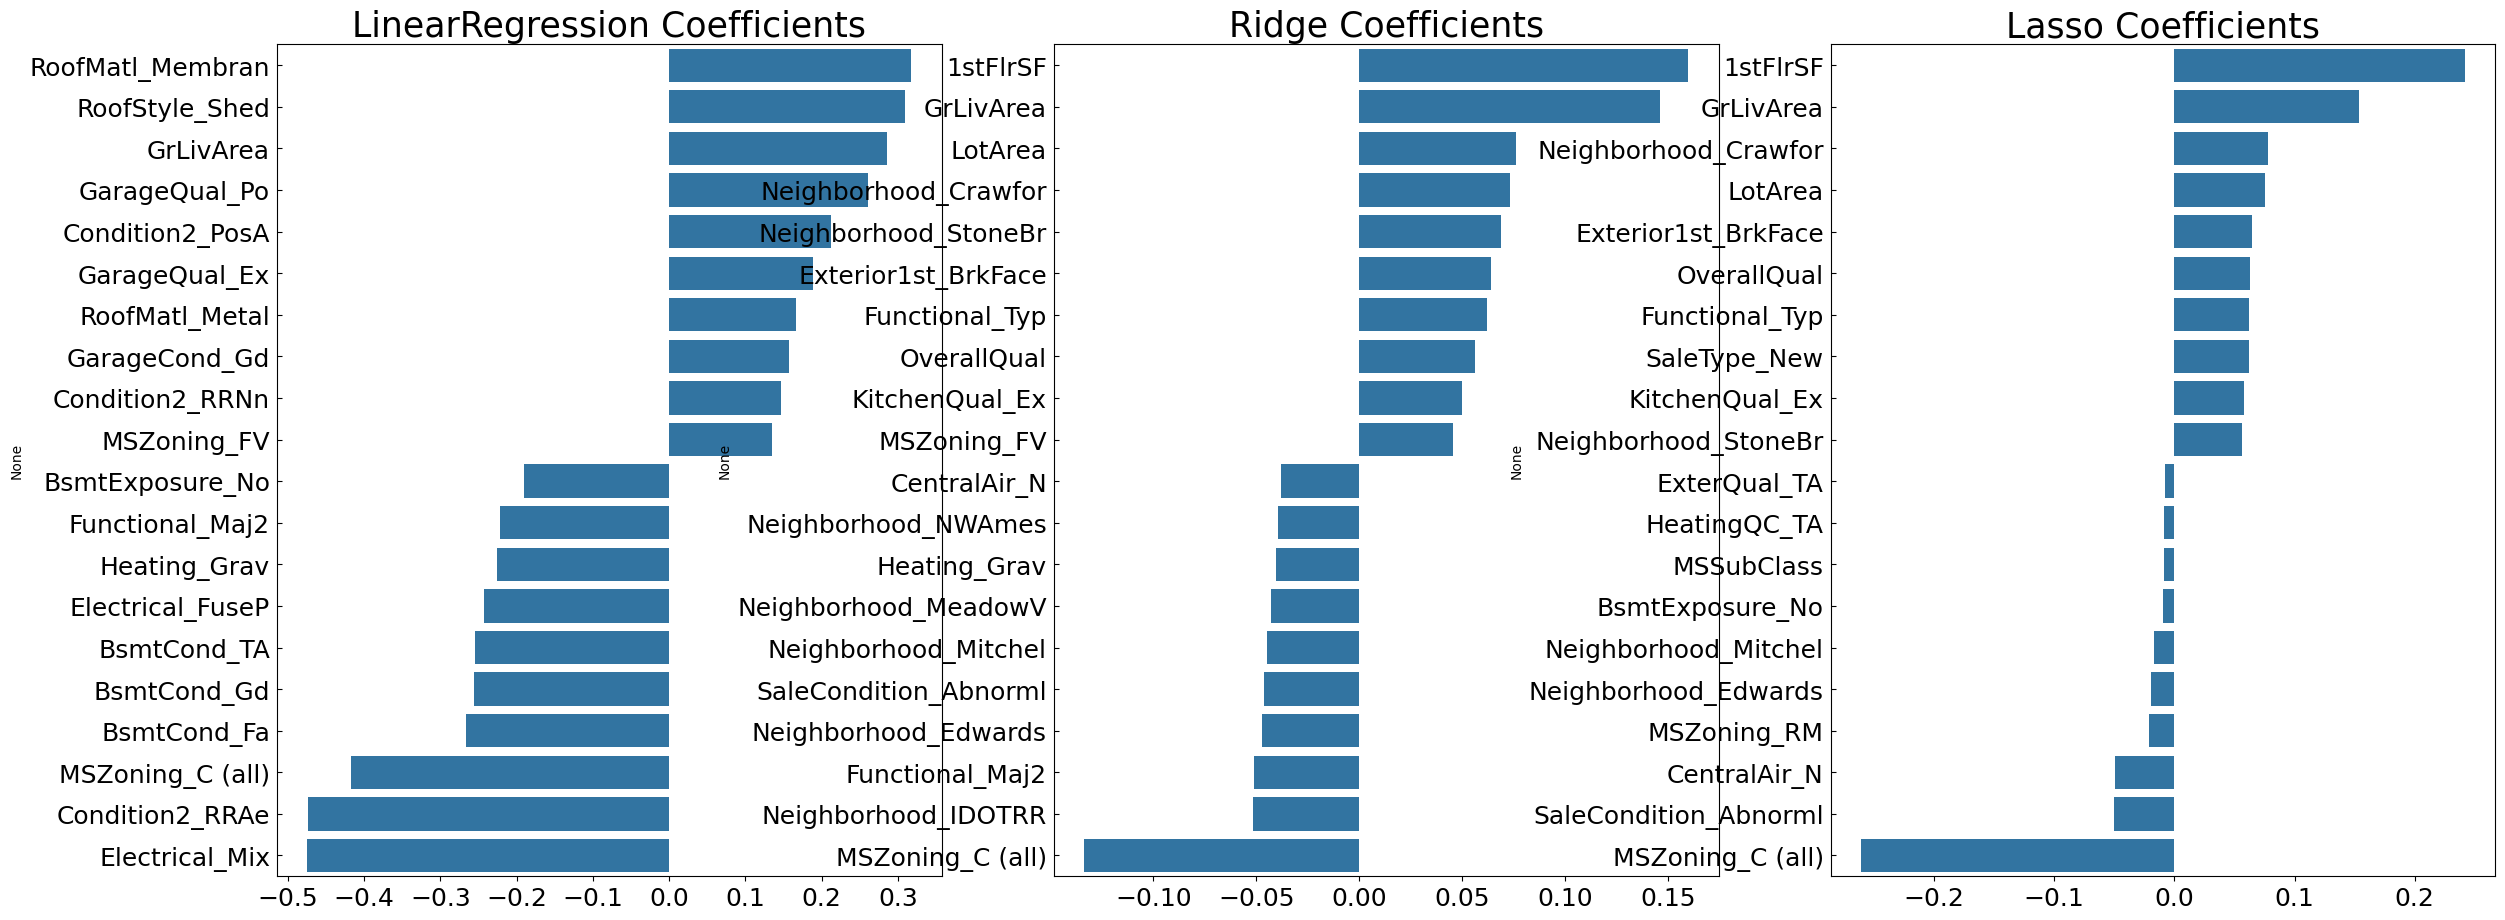

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout(pad=5.0)

    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])
        axs[i_num].set_title(f'{model.__class__.__name__} Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=5)

        for label in axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels():
            label.set_fontsize(18)

    plt.show()

# 모델 리스트 전달
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)


In [50]:
from sklearn.model_selection import cross_val_score
import numpy as np

def get_avg_rmse_c(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 Cross_val_Score) 수행. 모델별 CV RMSE 값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV RMSE 평균: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 ridge_reg, Lasso_reg 모델의 CV RMSE 값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_c(models)



Ridge CV RMSE 값 리스트 : [0.103 0.119 0.122 0.105 0.114]
Ridge CV RMSE 평균: 0.113

Lasso CV RMSE 값 리스트 : [0.103 0.117 0.122 0.106 0.112]
Lasso CV RMSE 평균: 0.112


In [52]:
from sklearn.model_selection import GridSearchCV
import numpy as np

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha: {2}'.format(
        model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))


ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }


print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


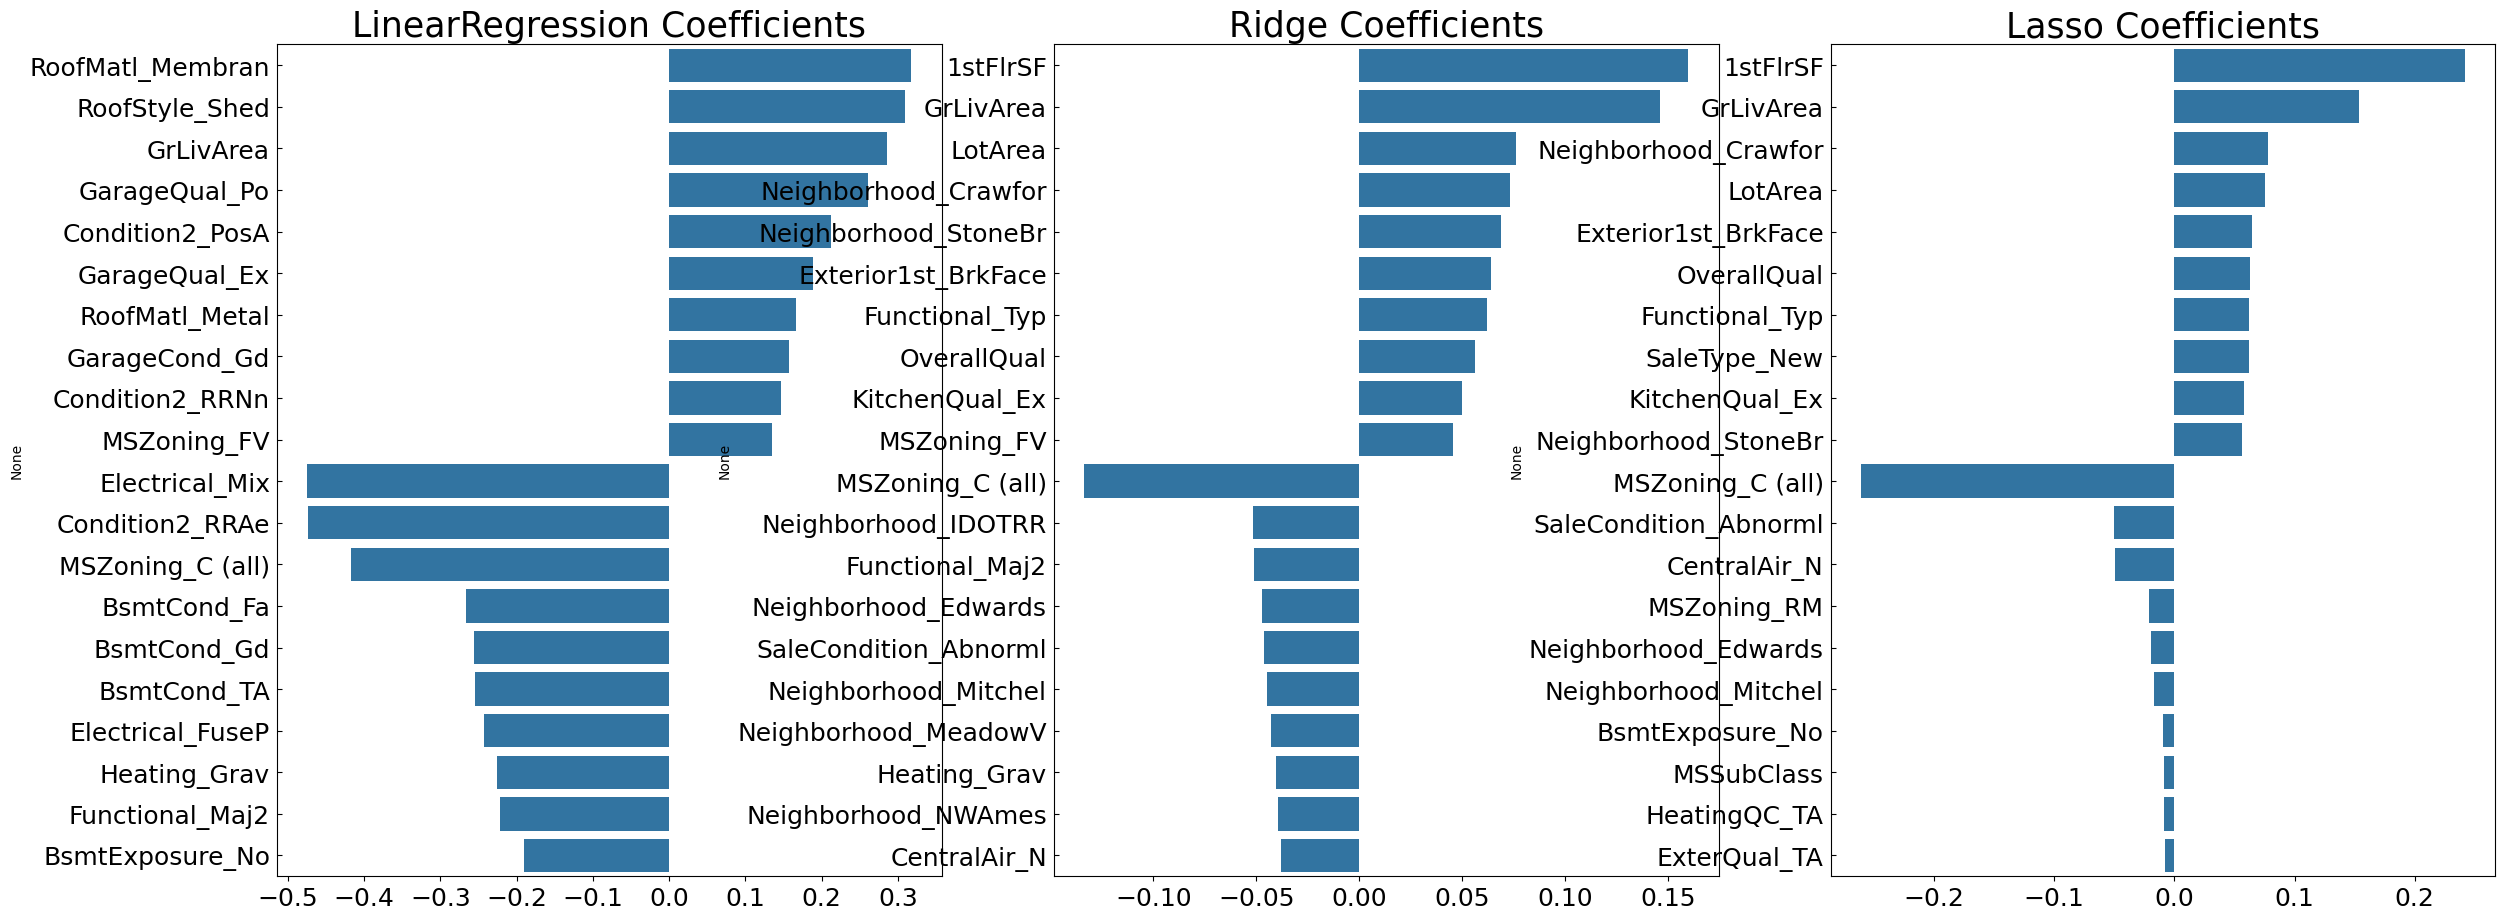

In [45]:
# 앞의 최적화된 alpha 값으로 모델 학습 및 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

In [46]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# 숫자형 칼럼들의 왜도 계산
skew_features = house_df[features_index].apply(lambda x: skew(x))

# Skew(왜도) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]

# 출력
print(skew_features_top.sort_values(ascending=False))


PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [47]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [16]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 원-핫 인코딩
house_df_ohe = pd.get_dummies(house_df)

# 타깃/피처 나누기
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2,
                                                    random_state=156)

# 최적 하이퍼파라미터 후보 설정
ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

# 최적 alpha 및 RMSE 출력
print_best_params(Ridge(), ridge_params)
print_best_params(Lasso(), lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha: {'alpha': 0.001}


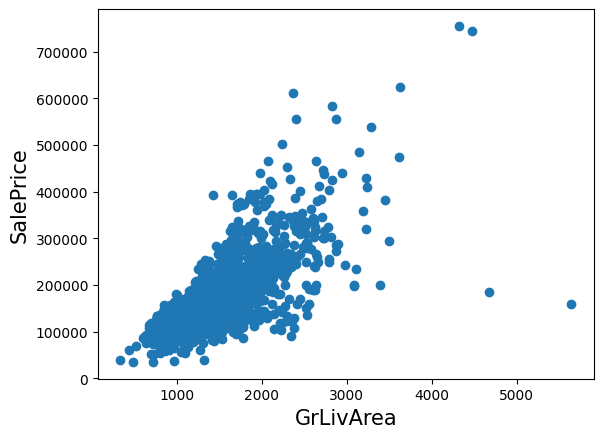

In [17]:
plt.scatter(x = house_df_org[ 'GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice'
, fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [18]:
import numpy as np

cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)

outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print("이상치 삭제 전 house_df_ohe shape:", house_df_ohe.shape)

house_df_ohe.drop(outlier_index, axis=0, inplace=True)

print('이상치 삭제 후 house_df_ohe shape:', house_df_ohe.shape)


이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe shape: (1458, 270)


In [19]:
from sklearn.model_selection import train_test_split
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)

ridge_params = { 'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

print_best_params(Ridge(), ridge_params)
print_best_params(Lasso(), lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha: {'alpha': 0.001}


In [20]:
from xgboost import XGBRegressor
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1206, 최적 alpha: {'n_estimators': 1000}


In [24]:
from lightgbm import LGBMRegressor
lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                               subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

In [27]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds [key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RNSE: {1}'.format(key, rmse))
# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)
# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {' 최종 혼합 ' : pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
# 최종 혼합 모델 , 개별 모델의 RNSE 값 출력
get_rmse_pred(preds)

 최종 혼합  모델의 RNSE: 0.10006075517615193
Ridge 모델의 RNSE: 0.10340697165289348
Lasso 모델의 RNSE: 0.10024171179335342


In [28]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg. fit(X_train, y_train)
lgbm_reg. fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {' 최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
 최종 혼합 모델의 RNSE: 0.10215383402419025
XGBM 모델의 RNSE: 0.10761344291735733
LGBM 모델의 RNSE: 0.10363891833477148


In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds 값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))

    print(model.__class__.__name__, ' model 시작 ')
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습 / 예측할 폴드 데이터 세트 추출
        print('lt 폴드 세트 : ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    # train_fold_pred 는 최종 메타 모델이 사용하는 학습 데이터 , test_pred_mean 은 테스트 데이터
    return train_fold_pred, test_pred_mean


In [35]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 Datarame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values
# 각 개별 기반 (Base) 모델이 생성한 학습용 / 테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
lt 폴드 세트 :  0  시작 
lt 폴드 세트 :  1  시작 
lt 폴드 세트 :  2  시작 
lt 폴드 세트 :  3  시작 
lt 폴드 세트 :  4  시작 
Lasso  model 시작 
lt 폴드 세트 :  0  시작 
lt 폴드 세트 :  1  시작 
lt 폴드 세트 :  2  시작 
lt 폴드 세트 :  3  시작 
lt 폴드 세트 :  4  시작 
XGBRegressor  model 시작 
lt 폴드 세트 :  0  시작 
lt 폴드 세트 :  1  시작 
lt 폴드 세트 :  2  시작 
lt 폴드 세트 :  3  시작 
lt 폴드 세트 :  4  시작 
LGBMRegressor  model 시작 
lt 폴드 세트 :  0  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
lt 폴드 세트 :  1  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [39]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,xgb_test, lgbm_test), axis=1)
# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)
# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습 / 테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso. fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error (y_test, final)
rmse = np.sqrt (mse)
print(' 스태킹 회귀 모델의 최종 RMSE 값은 :', mse)

 스태킹 회귀 모델의 최종 RMSE 값은 : 0.009417738137182453
